In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import pandas as pd
from download_utils import download_daily_weather, combine_daily_weather
import xarray as xr
import geopandas
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import numpy as np

In [3]:
save = False
plot = True

# Overview
This notebook is run every 3 days. Weather data is downloaded at daily resolution and averaged from the start of the month up to the current day. This is to get a better estimate for the weather variables every 3 days.

# Download weather data

In [10]:
end = pd.Timestamp.today().normalize()
end = pd.Timestamp("2025-12-27")
start = end.replace(day=1) - relativedelta(months=2) ## -2 months to be able to create lagged features
print("Start of forecast estimate: ", start)
print("End of forecast estimate: ", end)

# start = "2025-04-29"
# end = "2025-05-01"

Start of forecast estimate:  2025-10-01 00:00:00
End of forecast estimate:  2025-12-27 00:00:00


In [11]:
download_daily_weather(start, end)


2026-01-02 13:16:16,607 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2026-01-02 13:16:16,842 INFO [2025-12-11T00:00:00] Please note that a dedicated catalogue entry for this dataset, post-processed and stored in Analysis Ready Cloud Optimized (ARCO) format (Zarr), is available for optimised time-series retrievals (i.e. for retrieving data from selected variables for a single point over an extended period of time in an efficient way). You can discover it [here](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-timeseries?tab=overview)
2026-01-02 13:16:16,842 INFO Request ID is 9e0302e0-a925-49b5-bdde-41ccbf5a7287
2026-01-02 13:16:16,935 INFO status has been updated to accepted
2026-01-02 13:16:31,032 INFO status has been updated to running
2026-01-02 13:17:07,394 INFO status has been updated to successful


a32d3ae225f37457b94e0ba45394506d.zip:   0%|          | 0.00/4.23M [00:00<?, ?B/s]

2026-01-02 13:17:27,894 INFO [2025-12-11T00:00:00] Please note that a dedicated catalogue entry for this dataset, post-processed and stored in Analysis Ready Cloud Optimized (ARCO) format (Zarr), is available for optimised time-series retrievals (i.e. for retrieving data from selected variables for a single point over an extended period of time in an efficient way). You can discover it [here](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-timeseries?tab=overview)
2026-01-02 13:17:27,896 INFO Request ID is 3f5a354b-4788-433d-9f9c-a432f795b9c0



 Downloaded month 10 in 2025 



2026-01-02 13:17:28,449 INFO status has been updated to accepted
2026-01-02 13:17:42,177 INFO status has been updated to running
2026-01-02 13:17:49,842 INFO status has been updated to successful


61ef32d4f4377d5590ecbe4d697cbce0.zip:   0%|          | 0.00/3.94M [00:00<?, ?B/s]

2026-01-02 13:17:52,361 INFO [2025-12-11T00:00:00] Please note that a dedicated catalogue entry for this dataset, post-processed and stored in Analysis Ready Cloud Optimized (ARCO) format (Zarr), is available for optimised time-series retrievals (i.e. for retrieving data from selected variables for a single point over an extended period of time in an efficient way). You can discover it [here](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-timeseries?tab=overview)
2026-01-02 13:17:52,363 INFO Request ID is 226501e5-b021-4ea6-bdb2-3540a970ffe7



 Downloaded month 11 in 2025 



2026-01-02 13:17:52,422 INFO status has been updated to accepted
2026-01-02 13:18:06,670 INFO status has been updated to running
2026-01-02 13:18:25,794 INFO status has been updated to successful


70241fc0efc7cb1067f6a27c739ea595.zip:   0%|          | 0.00/3.39M [00:00<?, ?B/s]


 Downloaded month 12 in 2025 



In [12]:
weather_daily = combine_daily_weather()
weather_daily

<xarray.Dataset> Size: 36MB
Dimensions:     (valid_time: 88, latitude: 146, longitude: 141)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 704B 2025-10-01T12:00:00 ... 2025...
  * latitude    (latitude) float64 1kB 69.5 69.4 69.3 69.2 ... 55.2 55.1 55.0
  * longitude   (longitude) float64 1kB 10.5 10.6 10.7 10.8 ... 24.3 24.4 24.5
    expver      (valid_time) <U4 1kB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    t2m         (valid_time, latitude, longitude) float32 7MB nan nan ... 277.7
    tp          (valid_time, latitude, longitude) float32 7MB nan ... 0.0001802
    swvl1       (valid_time, latitude, longitude) float32 7MB nan nan ... 0.3712
    swvl2       (valid_time, latitude, longitude) float32 7MB nan nan ... 0.3745
    ssrd        (valid_time, latitude, longitude) float32 7MB nan ... 4.881e+05
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-02T12:16 GRIB to CDM+CF via cfgrib-0.9.1...

# Prepare dataset for model input

### Average into monthly statistics
This is to transform the data into the same format as our backfill datasets.

In [13]:
weather_agg = weather_daily.resample(valid_time='MS').map(
    lambda x: xr.Dataset({
        "t2m": x["t2m"].mean(dim="valid_time"),
        "tp": x["tp"].sum(dim="valid_time"),
        "swvl1": x["swvl1"].mean(dim="valid_time"),
        "swvl2": x["swvl2"].mean(dim="valid_time"),
        "ssrd": x["ssrd"].sum(dim="valid_time"),
    })
)
weather_agg


<xarray.Dataset> Size: 1MB
Dimensions:     (valid_time: 3, latitude: 146, longitude: 141)
Coordinates:
    number      int64 8B 0
  * latitude    (latitude) float64 1kB 69.5 69.4 69.3 69.2 ... 55.2 55.1 55.0
  * longitude   (longitude) float64 1kB 10.5 10.6 10.7 10.8 ... 24.3 24.4 24.5
  * valid_time  (valid_time) datetime64[ns] 24B 2025-10-01 2025-11-01 2025-12-01
Data variables:
    t2m         (valid_time, latitude, longitude) float32 247kB nan ... 276.0
    tp          (valid_time, latitude, longitude) float32 247kB 0.0 ... 0.01552
    swvl1       (valid_time, latitude, longitude) float32 247kB nan ... 0.395
    swvl2       (valid_time, latitude, longitude) float32 247kB nan ... 0.3965
    ssrd        (valid_time, latitude, longitude) float32 247kB 0.0 ... 2.185...

In [ ]:
# from download_utils import era5_grid_to_points_df

# era5_grid_df = era5_grid_to_points_df(weather_agg)
# era5_grid_df.to_csv('../data/country/era5points_df.csv', index=False)

### Create lagged features

In [15]:
# Convert to dataframe for easier manipulation
weather_features = weather_agg.to_dataframe().reset_index()
weather_features = weather_features.sort_values(['latitude', 'longitude', 'valid_time']).reset_index(drop=True)

# Create lagged features for each lat/lon combination
max_lag = 2
weather_vars = ['t2m', 'tp', 'swvl1', 'swvl2', 'ssrd']

# Group by location and create lags
lagged_data = []
for (lat, lon), group in weather_features.groupby(['latitude', 'longitude']):
    group = group.sort_values('valid_time').reset_index(drop=True)
    
    # Lagged features
    for lag in range(1, max_lag + 1):
        for var in weather_vars:
            group[f'{var}_lag{lag+1}'] = group[var].shift(lag)
    
    lagged_data.append(group)

In [22]:
weather_final = pd.concat(lagged_data, ignore_index=True)
weather_final.dropna(inplace=True)
weather_final.drop(columns=['number'], inplace=True)

d = {}
for v in weather_vars:
    d[v] = v+'_lag1'
d['latitude'] = 'Lat'
d['longitude'] = 'Lon'

weather_final.rename(columns=d, inplace=True)
weather_final = weather_final[sorted(list(weather_final.columns))]
weather_final["Lon"] = np.round(weather_final["Lon"], 1)
weather_final["Lat"] = np.round(weather_final["Lat"], 1)

weather_final

,Lat,Lon,ssrd_lag1,ssrd_lag2,ssrd_lag3,swvl1_lag1,swvl1_lag2,swvl1_lag3,swvl2_lag1,swvl2_lag2,swvl2_lag3,t2m_lag1,t2m_lag2,t2m_lag3,tp_lag1,tp_lag2,tp_lag3,valid_time
2,55.0,10.5,26374960.0,57946732.0,111332144.0,0.368101,0.364955,0.334737,0.368771,0.358120,0.318441,279.443054,280.878693,285.606628,0.015341,0.023522,0.073831,2025-12-01
5,55.0,10.6,26415656.0,57983484.0,111310336.0,0.367879,0.364825,0.334389,0.368636,0.358065,0.318485,279.432129,280.877899,285.596375,0.015337,0.023587,0.073856,2025-12-01
47,55.0,12.0,28411362.0,60494504.0,119752568.0,0.363425,0.364880,0.338017,0.364496,0.360316,0.324853,279.277771,280.636353,285.318695,0.011382,0.018314,0.056101,2025-12-01
50,55.0,12.1,28486064.0,60590808.0,119974560.0,0.363675,0.365382,0.339502,0.364634,0.360626,0.325493,279.288605,280.640076,285.305481,0.011486,0.018848,0.055625,2025-12-01
56,55.0,12.3,28732284.0,61268528.0,121889248.0,0.241728,0.244547,0.228525,0.245236,0.243248,0.218416,279.391846,280.680176,285.278259,0.010893,0.020913,0.055053,2025-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61745,69.5,24.1,0.0,4534644.0,43640832.0,0.216908,0.239728,0.252815,0.219166,0.245201,0.252953,265.579712,266.006348,275.279633,0.030012,0.016455,0.031202,2025-12-01
61748,69.5,24.2,0.0,4521106.0,43597824.0,0.219016,0.241172,0.252348,0.219912,0.246002,0.252164,265.624054,266.071503,275.341827,0.030344,0.016693,0.031450,2025-12-01
61751,69.5,24.3,0.0,4507432.0,43554632.0,0.221016,0.242586,0.251933,0.220639,0.246811,0.251439,265.668610,266.135895,275.402313,0.030677,0.016932,0.031698,2025-12-01
61754,69.5,24.4,0.0,4489310.0,43511024.0,0.220118,0.242842,0.253278,0.220479,0.247090,0.252991,265.582733,266.097565,275.432983,0.030996,0.017148,0.031927,2025-12-01


In [24]:
if save: weather_final.to_csv('../data/weather_daily/weather_' + str(end.day) + '_' + str(end.month) + '_' + str(end.year) + '_.csv', index=False)

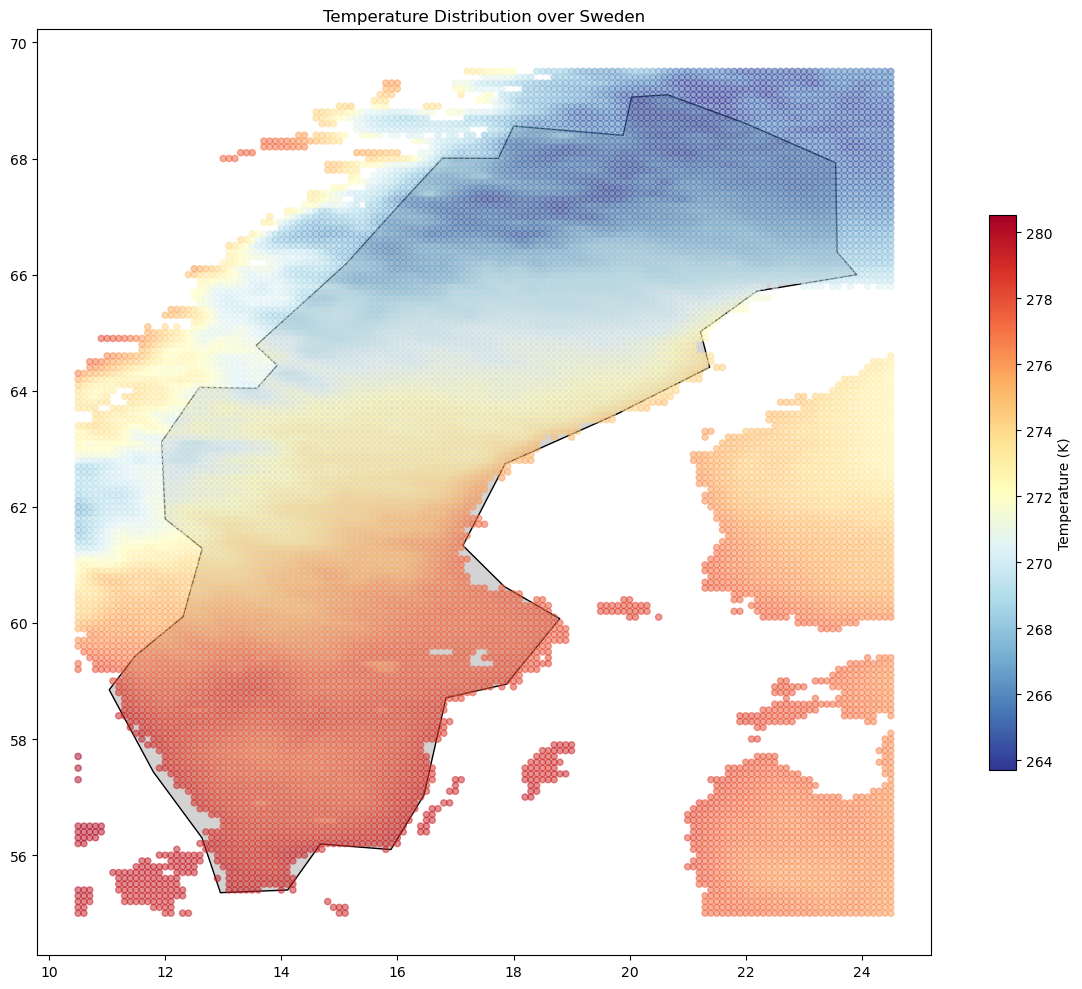

In [ ]:
gdf = geopandas.GeoDataFrame(
    weather_final, geometry=geopandas.points_from_xy(weather_final.Lon, weather_final.Lat)
    )

world = geopandas.read_file('../data/country/ne_110m_admin_0_sovereignty.shp')

# Plot Sweden with t2m as a heatmap
ax = world[world['NAME'] == 'Sweden'].plot(
    color='lightgrey', edgecolor='black', figsize=(12, 10))

# Plot the GeoDataFrame with t2m values as a heatmap
gdf.plot(ax=ax, column='t2m_lag1', cmap='RdYlBu_r', markersize=20, alpha=0.5, 
        legend=True, legend_kwds={'label': 'Temperature (K)', 'shrink': 0.6})

ax.set_title('Temperature Distribution over Sweden')
plt.tight_layout()
plt.show()